## Draw a Mass Spectrometry Fragmentation Tree Using RDKit

This utility plots a mass spectrometry fragmentation tree given the species' SMILES and their hierarchy, that is which species fragments into which other species.

Here's an annotated example.

![Annotated mass spectrometry fragmentation tree using the function mass_spec_frag_tree in this blog post](../images/mass_spec_frag_tree_CAIr_annotated.png)

*[Download this notebook from GitHub by right-clicking and choosing Save Link As...](https://raw.githubusercontent.com/bertiewooster/bertiewooster.github.io/main/_notebooks/2023-01-02-Mass-Spectrometry-Fragmentation-Tree.ipynb)*

## About Mass Spectrometry Fragmentation Trees

Mass spec determines the mass of an analyte (chemical species of interest) by ionizing (electrically charging) it, then directing the ion's trajectory using magnets. Mass spec actually measures the mass (m) to charge (z) ratio m/z, then the scientist uses other clues to determine the charge to then calculate the mass. Mass spec also often fragments (breaks into smaller pieces) the analyte, so that several species are often generated for even a single analyte.

Visualizing mass spec fragmentation trees is a helpful way to understand which species fragment into which other species. Tools such as the [SIRIUS software framework](https://bio.informatik.uni-jena.de/software/sirius/) have been developed to analyze fragmentation trees.

## Applying Mass Spec to Biomolecules

Mass spectrometric analysis is helpful for understanding biomolecules. For example, proteomics is informatics applied to proteins. In [bottom-up proteomics](https://en.wikipedia.org/wiki/Bottom-up_proteomics), scientists extract a mixture of proteins from a biological sample, break the proteins into smaller peptides (a process called digestion), analyze the mixture of peptides using mass spectrometry, then piece the peptides together to infer the original proteins.

Here, as a simple example of a small molecule with a biochemical role, we focus on a [riboside](https://en.wikipedia.org/wiki/Riboside), which is a [glycoside](https://en.wikipedia.org/wiki/Glycoside) (a molecule connecting a sugar and a functional group) of [ribose](https://en.wikipedia.org/wiki/Ribose) (a simple sugar). [Madrova et al](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0208947#sec019) studied ribosides and provide a nice example of a mass spec fragmentation tree where several of the fragments' chemical structures were determined.

Mass spectrometry can be used iteratively to fragment a parent species, characterize the fragments, and then further fragment selected fragments. Doing two steps is called MS-MS, or mass spectrometry-mass spectrometry. Madrova et al. used an ion cyclotron resonance (ICR) mass spectrometer, which allows ions to be trapped so that any number of iterations can be done in a single instrument on a single sample. This is referred to as MS<sup>n</sup>, meaning n iterations of mass spec, where n can be 2, 3, 4, etc.

Two kinds of molecular weight are commonly used: [exact and average molecular weight](https://msfacility.missouri.edu/calculating.html). Average molecular weight reflects the distribution of isotopes of the molecule's atoms, whereas exact molecular weight gives the molecular weight of the most common isotopes of each atom in the molecule. When modeling mass spectra, we use the exact rather than average molecular weight, because mass spectra resolve the different isotopes of each atom, for example carbon-12 and carbon-13.

## Code for Generating Mass Spec Fragmentation Tree

In [4]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFMCS

In [5]:
# Utilities
def flatten_twoD_list(twoD_list: list[list]) -> list:
    return [item for sublist in twoD_list for item in sublist]
    
def longest_row(twoD_list: list[list]) -> int:
    return max(len(row) for row in twoD_list)

def get_fraction(num, denom):
    if denom:
        return num / denom
    else:
        return 0
        # return None

In [9]:

def concat_grids_horizontally(grid1:list[list[str]], grid2:list[list[str]]) -> list[list[str]]:
    """Concatenate two nested lists horizontally, for example
    inputs [['a'],['b'],['c']] and [['d'], ['e'], ['f']] 
    produce [['a', 'd'], ['b', 'e'], ['c', 'f']]

    :returns: The combined grid, a two-deep nested list of strings
    :param grid1: The first grid, a two-deep nested list of strings
    :param grid2: The second grid, a two-deep nested list of strings
    """
    if grid1 == [[]]:
        combined = grid2
    elif grid2 == [[]]:
        combined = grid1
    else:
        combined = []
        for row_counter in range(len(grid1)):
            combined += [grid1[row_counter] + grid2[row_counter]]
    return combined

class NonBinTree:
    """
    Nonbinary tree class
    Note that this class is not designed to sort nodes as they are added to the tree;
    the assumption is that they should be ordered in the order added
    Adapted from https://stackoverflow.com/questions/60579330/non-binary-tree-data-structure-in-python#60579464
    """

    def __init__(self, val:str, label=None):
        """Create a NonBinTree instance"""
        self.val = val
        self.label = label
        self.nodes = []

    def add_node(self, val:str, label=None):
        """Add a node to the tree and return the new node"""
        self.nodes.append(NonBinTree(val, label))
        return self.nodes[-1]

    def __repr__(self) -> str:
        """Print out the tree as a nested list"""
        return f"NonBinTree({self.val}): {self.nodes}"

    def get_ncols(self) -> int:
        """Get the number of columns in the tree"""
        self.ncols = 0
        if len(self.nodes) > 0:
            # If there are nodes under this one, call get_ncols on them recursively
            for node in self.nodes:
                self.ncols += node.get_ncols()
        else:
            # If there are no nodes under this one, add 1 for this node
            self.ncols += 1
        return self.ncols

    def get_max_depth(self) -> int:
        """Get the maximum depth of the tree"""
        max_depth = 0
        if len(self.nodes) > 0:
            for node in self.nodes:
                this_depth = node.get_max_depth()
                max_depth = max(this_depth + 1, max_depth)
        else:
            max_depth = max(1, max_depth)
        self.max_depth = max_depth
        return self.max_depth

    def get_grids(self) -> list[list[str]]:
        """
        Get 2x two-dimensional grids for molecules' SMILES and labels where
        each row is a level in the fragment hierarchy, and
        the columns serve to arrange the fragments horizontally
        """
        # Call methods to calculate self.ncols and self.max_depth
        self.get_ncols()
        self.get_max_depth()

        # Create top row: Node value, then the rest of columns are blank (empty strings)
        grid = [[self.val] + [""] * (self.ncols - 1)]
        grid_label = [[self.label] + [""] * (self.ncols - 1)]

        n_nodes = len(self.nodes)

        if n_nodes > 0:
            nodes_grid = [[]]
            nodes_grid_label = [[]]

            # Iterate through the chile nodes
            for node_counter, node in enumerate(self.nodes):
                # Recursively call this function to get the grid for children
                node_grid, node_grid_label = node.get_grids()

                # Add spacer rows if needed
                node_grid_rows = len(node_grid)
                rows_padding = self.max_depth - node_grid_rows - 1
                for padding in range(rows_padding):
                    padding_to_add = [[""] * len(node_grid[0])]
                    node_grid += padding_to_add
                    node_grid_label += padding_to_add

                nodes_grid = concat_grids_horizontally(nodes_grid, node_grid)
                nodes_grid_label = concat_grids_horizontally(nodes_grid_label, node_grid_label)

            grid += nodes_grid
            grid_label += nodes_grid_label

        return grid, grid_label

In [10]:
def mass_spec_frag_tree(non_bin_tree, ndigits:int or None = 2, addHs:bool=False, verbose:bool=False, **kwargs):
    """
    Draw a mass spectrometry fragmentation tree

    :returns: RDKit grid image, and (if verbose=True) fragment tree as 2D (nested) list
    :rtype: RDKit grid image, and (if verbose=True) molecules as list[list[mol]], labels as list[list[str]], mass (Daltons) as list[list[float]], m/z (mass-to-charge ratio) as list[list[float]]
    :param non_bin_tree: The NonBinTree corresponding to the parent compound
    :param ndigits: The number of digits to round mass and m/z (mass-to-charge ratio) values to. Use None to round to integer values, for example 92.
    :param addHs: Whether to add (show) hydrogen atoms in the molecular structures; default is False.
    :param verbose: Whether to return verbose output; default is False so calling this function will present a grid image automatically
    """

    # Do all processing on grids (2D lists)

    smiles_grid, labels_grid = non_bin_tree.get_grids()
    row_length = longest_row(smiles_grid)

    # Convert SMILES into molecules, adding Hs (hydrogen atoms) if requested
    mols_raw_grid = [[Chem.MolFromSmiles(smile) for smile in row] for row in smiles_grid]
    if addHs:
        mols_grid = [[Chem.AddHs(mol_raw) for mol_raw in row] for row in mols_raw_grid]
    else:
        mols_grid = mols_raw_grid

    # Determine masses, charges, and m/z
    masses_grid = [[Descriptors.ExactMolWt(mol) for mol in row] for row in mols_grid]
    masses_rounded_grid = [[round(mass, ndigits) for mass in row] for row in masses_grid]
    charges_grid = [[Chem.GetFormalCharge(mol) for mol in row] for row in mols_grid]

    mzs_grid = []
    for row_index in range(len(masses_grid)):
        mzs_row = []
        for col_index in range(len(masses_grid[0])):
            # print(f"{smiles_grid[row_index][col_index]}")
            mzs = get_fraction(masses_grid[row_index][col_index], charges_grid[row_index][col_index])
            mzs_row += [mzs]
        mzs_grid += [mzs_row]

    mzs_rounded_grid = [[round(mz, ndigits) for mz in row] for row in mzs_grid]

    # Create legend for each species:
    # <SMILES>, <mass> Da OR m/z=<m/z>
    # where m/z is used if the species is charged, and the mass if used if the species is neutral
    descrs_grid = [[]]
    descrs_row = []
    for row_index in range(len(mols_grid)):
        descrs_row = []
        for col_index in range(len(mols_grid[0])):
            descr = "  " + labels_grid[row_index][col_index] + ", " #+ ": "
            if charges_grid[row_index][col_index] != 0:
                descr += "m/z=" + str(mzs_rounded_grid[row_index][col_index]) + "  "
            else:
                descr += str(masses_rounded_grid[row_index][col_index]) + " Da"
            descrs_row += [descr]
        descrs_grid += [descrs_row]

    # Flatten grids (2D lists) into 1D lists for MolsToGridImage
    mols = flatten_twoD_list(mols_grid)
    descrs = flatten_twoD_list(descrs_grid)

    drawing = Draw.MolsToGridImage(mols, legends=descrs, molsPerRow=row_length, **kwargs)
    if verbose:
          return drawing, smiles_grid, labels_grid, mols_grid, masses_grid, charges_grid, mzs_grid
    else:
          return drawing

## Riboside Example

Carboxyaminoimidazole riboside (CAIr) was studied by [Madrova et al.](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0208947#sec019). To put an electrical charge on the neutral CAIr molecule so it could be analyzed with mass spec, they used electrospray ionization. This ionization technique often protonates (adds a proton, that is H<sup>+</sup>, which is a hydrogen atom stripped of its electron) neutral molecules using a [proton source such as acetic acid](https://en.wikipedia.org/wiki/Electrospray_ionization#Ionization_mechanism). The parent ion, denoted as CAIr.H+ below, thus weighs approximately one Dalton (which is the atomic mass of a [proton](https://en.wikipedia.org/wiki/Proton)) more than the neutral species.

Mass spec typically analyzes gas-phase ions in high vacuum, that is, very low pressures. Species that would not be stable in a condensed phase (liquid or solid) can be stable in the gas phase, and they can be analyzed by mass spec. As a result, some of the chemical formulas and SMILES strings may seem unusual. For example, in SMILES, `C` is a (non-aromatic) carbon atom which is assumed to have four bonds, and any bonds not explicitly stated are assumed to be to hydrogen atoms. But to specify that a carbon atom has a single positive charge and one bound hydrogen atom, you need to include the hydrogen atoms explicitly, for example `[CH+]`. Also, to add a proton when its location on the species is not known, I used the [disconnected structure](https://chemicbook.com/2021/02/13/smiles-strings-explained-for-beginners-part-1.html) notation of a dot, `.[H+]`

### Enter Mass Spec Fragmentation Data and Create the Tree

[15:31:00] WARNING: not removing hydrogen atom without neighbors


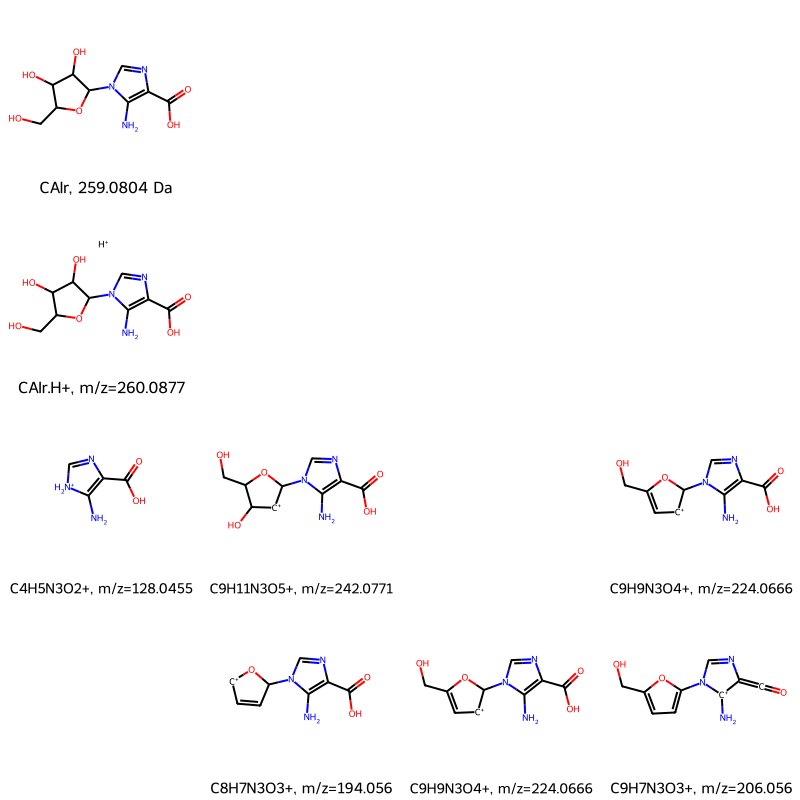

In [11]:
# Input SMILES
CAIr_smiles = "Nc1c(C(=O)O)ncn1C2OC(CO)C(O)C2O"
CAIr_protonated_smiles = CAIr_smiles + ".[H+]"
C9H11N3O5_smiles = "Nc1c(C(=O)O)ncn1C2[CH+]C(O)C(CO)O2"
C9H9N3O4_smiles = "Nc1c(C(=O)O)ncn1C2[CH+]C=C(CO)O2"
C9H7N3O3_smiles = "N[c+]1c(=C=O)ncn1c2ccc(CO)o2"
C8H7N3O3_smiles = "Nc1c(C(=O)O)ncn1C2C=C[CH+]O2"
C4H5N3O2_smiles = "NC1=C(C(=O)O)N=C[NH2+]1"

# Create mass spectrometry fragmentation hierarchy
CAIr = NonBinTree(CAIr_smiles, "CAIr")
CAIr_protonated = CAIr.add_node(CAIr_protonated_smiles, "CAIr.H+")
C4H5N3O2 = CAIr_protonated.add_node(C4H5N3O2_smiles, "C4H5N3O2+")
C9H11N3O5 = CAIr_protonated.add_node(C9H11N3O5_smiles, "C9H11N3O5+")
C8H7N3O3 = C9H11N3O5.add_node(C8H7N3O3_smiles, "C8H7N3O3+")
C9H9N3O4_ms4 = C9H11N3O5.add_node(C9H9N3O4_smiles, "C9H9N3O4+")
C9H9N3O4_ms3 = CAIr_protonated.add_node(C9H9N3O4_smiles, "C9H9N3O4+")
C9H7N3O3 = C9H9N3O4_ms3.add_node(C9H7N3O3_smiles, "C9H7N3O3+")

mass_spec_frag_tree(CAIr, 4)

In this tree, the top row is the neutral molecule CAIr. Subsequent rows represent iterations of mass spec: the second row is MS<sup>2</sup>, the third row is MS<sup>3</sup>, and the fourth row is MS<sup>4</sup>. This function `mass_spec_frag_tree` labels each species with either
- for neutral species, its mass; for example, the mass of CAIr is 259.0804 Da
- for ions, its mass to charge ratio m/z; for example, the mass to charge ratio of protonated CAIr (CAIr.H+) is 260.0877.

## Input Parameters for `mass_spec_frag_tree`

Parameters you can pass to `mass_spec_frag_tree` are:
- `non_bin_tree` (required) the NonBinTree object for the mass spec hierarchy.
- `ndigits` (integer or `None`) the number of digits beyond the decimal point to use for showing masses or m/z ratios in the drawing legends. Use `None` to round to the nearest integer. Note that `ndigits` only affects the legends displayed in the drawing; when using `verbose=True`, non-rounded outputs will be given regardless of the value of `ndigits`.
- `addHs` (Boolean, so True or False (default)): Whether to display hydrogen atoms in the drawing. Note that this does not actually add or remove hydrogens; the mass is unaffected, only the *display* of hydrogen atoms is changed.
- `verbose` (Boolean, so True or False (default)): Whether to return results in addition to the drawing, which you can manipulate in other ways. Details are given next.

## Get Additional Data

If you want `mass_spec_frag_tree` to return not just the grid image, but also properties for each species in the tree, set `verbose=True`:

In [12]:
drawing, smiles_grid, labels_grid, mols_grid, masses_grid, charges_grid, mzs_grid = mass_spec_frag_tree(CAIr, 4, verbose=True)

[15:31:00] WARNING: not removing hydrogen atom without neighbors


You then must explicitly call the image to draw it:

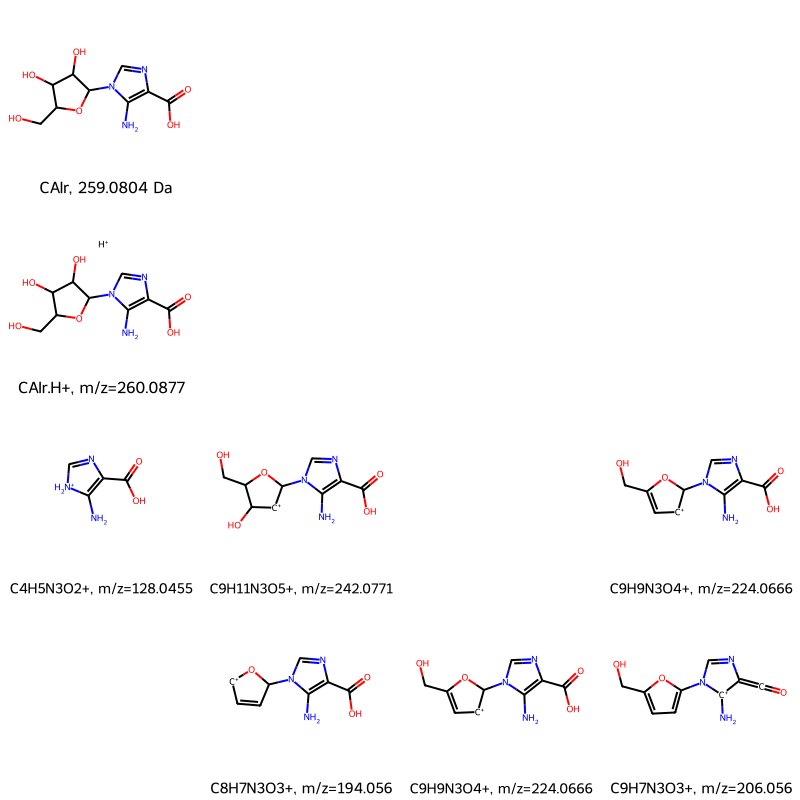

In [13]:
drawing

The remaining parameters are all in grid format, meaning a two-dimensional nested list where the top-level list represents a row in the drawing, and each element of a lower-level represents a cell in the drawing. This format lets you access the data for each chemical species, for example any `_grid[0][0]` entry represents the top-left species in the drawing.

`smiles_grid` contains the SMILES string for each species. If there is no species in a cell, its entry is an empty string, `''`.

In [14]:
smiles_grid

[['Nc1c(C(=O)O)ncn1C2OC(CO)C(O)C2O', '', '', ''],
 ['Nc1c(C(=O)O)ncn1C2OC(CO)C(O)C2O.[H+]', '', '', ''],
 ['NC1=C(C(=O)O)N=C[NH2+]1',
  'Nc1c(C(=O)O)ncn1C2[CH+]C(O)C(CO)O2',
  '',
  'Nc1c(C(=O)O)ncn1C2[CH+]C=C(CO)O2'],
 ['',
  'Nc1c(C(=O)O)ncn1C2C=C[CH+]O2',
  'Nc1c(C(=O)O)ncn1C2[CH+]C=C(CO)O2',
  'N[c+]1c(=C=O)ncn1c2ccc(CO)o2']]

`labels_grid` contains the supplied string for each species. If there is no species in a cell, its entry is an empty string, `''`.

In [15]:
labels_grid

[['CAIr', '', '', ''],
 ['CAIr.H+', '', '', ''],
 ['C4H5N3O2+', 'C9H11N3O5+', '', 'C9H9N3O4+'],
 ['', 'C8H7N3O3+', 'C9H9N3O4+', 'C9H7N3O3+']]

`mols_grid` contains the RDKit molecule object for each species. If there is no species in a cell, its entry is still an RDKit molecule, but represents a null molecule (no atoms).

In [16]:
mols_grid

[[<rdkit.Chem.rdchem.Mol at 0x16a022a40>,

`masses_grid` contains the mass for each species. If there is no species in a cell, its entry is zero.

In [17]:
masses_grid

[[259.080435136, 0.0, 0.0, 0.0],
 [260.08771158809003, 0.0, 0.0, 0.0],
 [128.04545285209, 242.07714690409, 0.0, 224.06658222009],
 [0.0, 194.05601753609, 224.06658222009, 206.05601753609]]

`charges_grid` contains the charge for each species. If there is no species in a cell, its entry is zero.

In [18]:
charges_grid

[[0, 0, 0, 0], [1, 0, 0, 0], [1, 1, 0, 1], [0, 1, 1, 1]]

`mzs_grid` contains the mass to charge for each species. If there is no charged species in a cell, its entry is zero.

In [19]:
mzs_grid

[[0, 0, 0, 0],
 [260.08771158809003, 0, 0, 0],
 [128.04545285209, 242.07714690409, 0, 224.06658222009],
 [0, 194.05601753609, 224.06658222009, 206.05601753609]]

## Toluene Example: Showing Hydrogen Atoms

As a second example, consider toluene, a common organic solvent. [Toluene's mass spec fragmentation tree](https://en.wikipedia.org/wiki/Fragmentation_(mass_spectrometry)) is also known and is reproduced below. In this case, the parent is produced by removing an electron from the neutral species. As a result, the mass of the toluene ion is nearly the same as that of toluene, because an [electron's mass](https://en.wikipedia.org/wiki/Electron_mass) is less than one-thousandth of a Dalton.

One difficulty in mentally parsing unusual gas-phase chemical structures is counting the number of hydrogen atoms. To help, `mass_spec_frag_tree` lets you show hydrogen atoms using `addHs=True`.

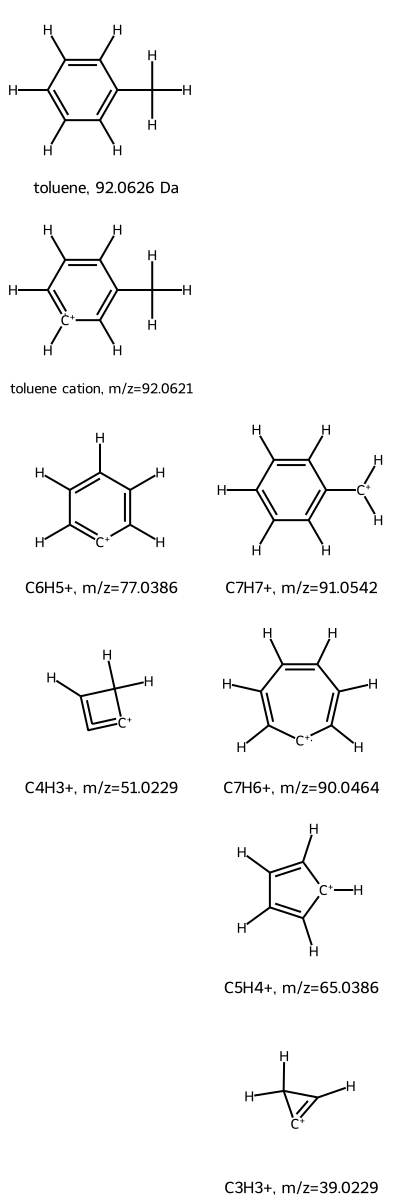

In [20]:
# Create mass spectrometry fragmentation hierarchy
toluene = NonBinTree("Cc1ccccc1", "toluene")
toluene_cation = toluene.add_node("CC1=C[CH+]=CC=C1", "toluene cation")
C6H5_cation = toluene_cation.add_node("[C+]1=CC=CC=C1", "C6H5+")
C4H3_cation = C6H5_cation.add_node("[C+]1=C=CC1", "C4H3+")
C7H7_hex_ring_cation = toluene_cation.add_node("[CH2+]c1ccccc1", "C7H7+")
C7H7_hept_ring_cation = C7H7_hex_ring_cation.add_node("[C+]1C=CC=CC=C1", "C7H6+")
C5H5_cation = C7H7_hept_ring_cation.add_node("[CH+]1C=CC=C1", "C5H4+")
C3H3_cation = C5H5_cation.add_node("[C+]1=CC1", "C3H3+")

# Draw tree
mass_spec_frag_tree(toluene, ndigits=4, addHs=True)